In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import time
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from torch.utils.data import TensorDataset,DataLoader, random_split

fnexpr='exprLOW.csv'
fnmet='methylLOW.csv'
fnassig='assignLOW.csv'
nsamp=10000
fnmodel='MTETRANSF3-10K.pth'


#Función para contar número de parámetros del modelo
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
# Definir el modelo Transformer
class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        from torch.nn import TransformerEncoder, TransformerEncoderLayer
        self.model_type = 'Transformer'
        self.src_mask = None

        self.encoder = nn.Linear(input_dim, nhid)
        self.transformer_encoder = TransformerEncoder(TransformerEncoderLayer(nhid, nhead, nhid, dropout), nlayers)
        self.decoder = nn.Linear(nhid, output_dim)

    def forward(self, src, src_mask):
        src = self.encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output
        
# Leer datos
expression_data = pd.read_csv(fnexpr)
methylation_data = pd.read_csv(fnmet)
assign_data = pd.read_csv(fnassig)

expression_data = expression_data.iloc[:, 1:]
methylation_data = methylation_data.iloc[:, 1:]
assign_data = assign_data.iloc[:, 2:]

# Convertir todas las columnas a tipo float
expression_data = expression_data.apply(pd.to_numeric, errors='coerce')
methylation_data = methylation_data.apply(pd.to_numeric, errors='coerce')
assign_data = assign_data.apply(pd.to_numeric, errors='coerce')

# Lidiar con valores NaN (si los hay). Pone 0(CAMBIAR)
#expression_data.fillna(0, inplace=True)
#methylation_data.fillna(0, inplace=True)
#assign_data.fillna(0, inplace=True)

#Normalizamos
scaler = MinMaxScaler()

# Asumiendo que expression_data, methylation_data y assign_data son tus DataFrames
expression_data_scaled = scaler.fit_transform(expression_data)
methylation_data_scaled = scaler.fit_transform(methylation_data)
assign_data_scaled =assign_data

# Convertir a DataFrame
expression_data = pd.DataFrame(expression_data_scaled, index=expression_data.index, columns=expression_data.columns)
methylation_data = pd.DataFrame(methylation_data_scaled, index=methylation_data.index, columns=methylation_data.columns)
assign_data = pd.DataFrame(assign_data_scaled, index=assign_data.index, columns=assign_data.columns)

#print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device="cpu"

expression_data_tensor = torch.FloatTensor(expression_data.values).to(device)
methylation_data_tensor = torch.FloatTensor(methylation_data.values).to(device)
assign_data_tensor = torch.FloatTensor(assign_data.values).to(device)

# Dividir en conjuntos de entrenamiento y prueba
dataset = TensorDataset(expression_data_tensor, methylation_data_tensor)
train_size = int(0.9 * len(dataset))  # Ajusta esto según tu necesidad
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Convertir los Subset en tensores para el entrenamiento
expression_train, methylation_train= zip(*[(e, m) for e, m in train_dataset])
expression_train = torch.stack(expression_train)
methylation_train = torch.stack(methylation_train)
#assign_train = torch.stack(assign_train)

# Convertir los Subset en tensores para la validación/prueba
expression_test, methylation_test = zip(*[(e, m) for e, m in test_dataset])
expression_test = torch.stack(expression_test)
methylation_test = torch.stack(methylation_test)
#assign_test = torch.stack(assign_test)
input_dim = methylation_data.shape[1]
output_dim = expression_data.shape[1]
# Parámetros del Transformer

nhead = 8  # Número de cabezas en el multiheadattention
nhid = 2048  # Dimensión oculta
nlayers = 4  # Número de capas TransformerEncoderLayer
dropout = 0.2  # Probabilidad de dropout
# Entrenamiento
def generate_square_subsequent_mask(sz):
    mask = torch.triu(torch.ones(sz, sz), 1)
    mask = mask.masked_fill(mask == 1, float('-inf'))
    return mask


In [2]:



# Crear instancia del modelo
model = TransformerModel(input_dim, output_dim, nhead, nhid, nlayers, dropout).to(device)

# Hiperparámetros y optimizador
lr = 0.0002  # Tasa de aprendizaje
optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
criterion = nn.MSELoss()



def train_epoch(model, data_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    for batch in data_loader:
        expression_data, methylation_data = batch
        expression_data = expression_data.to(device)
        methylation_data = methylation_data.to(device)

        optimizer.zero_grad()
        src_mask = generate_square_subsequent_mask(methylation_data.size(0)).to(device)
        output = model(methylation_data, src_mask)
        loss = criterion(output, expression_data)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)



# Configuración del entrenamiento
n_epochs = 100  # Número de épocas
best_val_loss = float('inf')






# Crear DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Bucle de entrenamiento
for epoch in range(n_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    #test_loss = evaluate(model, test_loader, criterion, device)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}')

    # Guardar el modelo si es el mejor hasta ahora
    if train_loss < best_val_loss:
        best_val_loss = train_loss
        torch.save(model.state_dict(), fnmodel)
        print(f"Saved model with Train Loss: {train_loss:.6f}")




/home/fede/PyEnv/PB/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1, Train Loss: 0.1667
Saved model with Train Loss: 0.166720
Epoch 2, Train Loss: 0.0678
Saved model with Train Loss: 0.067840
Epoch 3, Train Loss: 0.0398
Saved model with Train Loss: 0.039769
Epoch 4, Train Loss: 0.0319
Saved model with Train Loss: 0.031945
Epoch 5, Train Loss: 0.0305
Saved model with Train Loss: 0.030488
Epoch 6, Train Loss: 0.0299
Saved model with Train Loss: 0.029869
Epoch 7, Train Loss: 0.0295
Saved model with Train Loss: 0.029532
Epoch 8, Train Loss: 0.0293
Saved model with Train Loss: 0.029350
Epoch 9, Train Loss: 0.0293
Saved model with Train Loss: 0.029260
Epoch 10, Train Loss: 0.0291
Saved model with Train Loss: 0.029127
Epoch 11, Train Loss: 0.0291
Epoch 12, Train Loss: 0.0290
Saved model with Train Loss: 0.029011
Epoch 13, Train Loss: 0.0290
Epoch 14, Train Loss: 0.0290
Saved model with Train Loss: 0.028950
Epoch 15, Train Loss: 0.0289
Saved model with Train Loss: 0.028902
Epoch 16, Train Loss: 0.0289
Epoch 17, Train Loss: 0.0289
Epoch 18, Train Loss: 

/home/fede/PyEnv/PB/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-12-04 14:16:47.637191: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-04 14:16:47.659125: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-04 14:16:47.659146: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-04 14:16:47.659163: E

True


/home/fede/PyEnv/PB/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


MSE entre los datos de metilación reales y los generados: 0.029145698994398117
RMSE: 0.17072111467067605
PCC: 0.46823085718074914


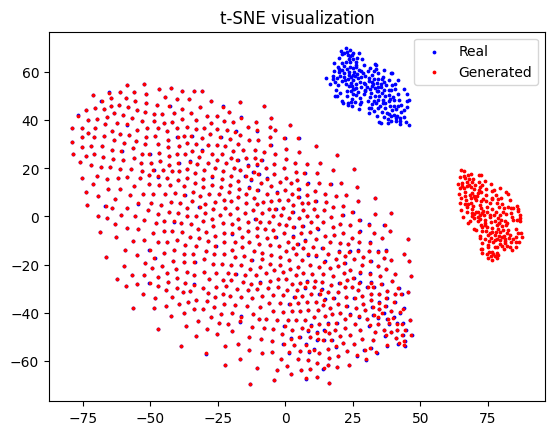

/home/fede/PyEnv/PB/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


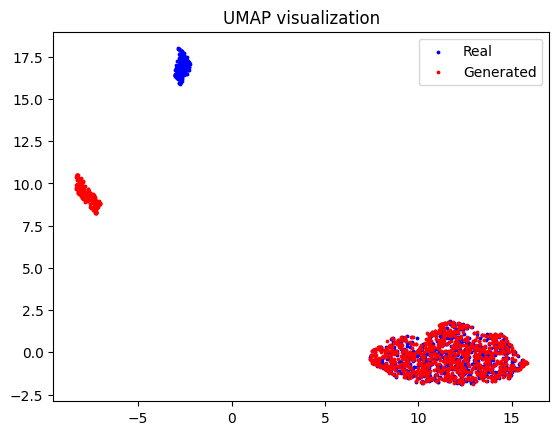

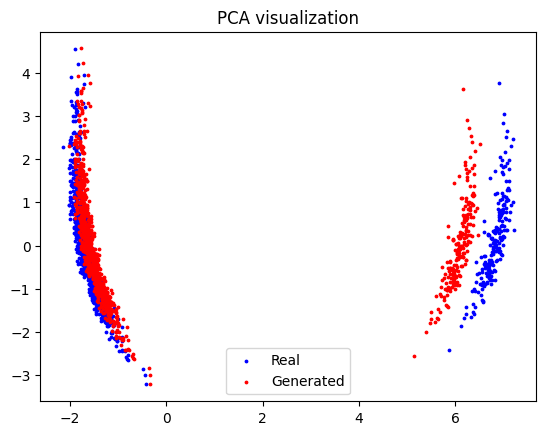

In [3]:
import torch
import pandas as pd
from sklearn.metrics import mean_squared_error
from torch.nn.functional import mse_loss
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from scipy.stats import wasserstein_distance, ks_2samp
import sys
import umap
from scipy.stats import pearsonr
from math import sqrt
# Leer datos
#expression_data_test_tensor, methylation_data_test_tensor = zip(*[(e, m) for e, m in test_dataset])


# Convertir los tensores a numpy y luego a DataFrame de pandas
expression_data_test_np = expression_test.cpu().numpy()
methylation_data_test_np = methylation_test.cpu().numpy()

#expression_data_test_tensor = torch.FloatTensor(expression_data_test_np).to(device)
expression_data_test_df = pd.DataFrame(expression_data_test_np)
methylation_data_test_df = pd.DataFrame(methylation_data_test_np)



X_real = pd.concat([expression_data_test_df, methylation_data_test_df], axis=1)
# Concatenar los datos
#combined_data =torch.FloatTensor(np.hstack((expression_data, methylation_data,assign_data)))
print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device="cpu"

# Cargar el modelo Transformer previamente entrenado
model = TransformerModel(input_dim, output_dim, nhead, nhid, nlayers, dropout).to(device)  # Asegúrate de proporcionar los parámetros correctos aquí
model.load_state_dict(torch.load(fnmodel))
model.eval()
model.to(device)

# Preparar los datos de expresión para la inferencia
#expression_data_test_tensor = torch.FloatTensor(expression_data_test.values).to(device)

# Generar datos de metilación utilizando el modelo Transformer
with torch.no_grad():
    # Necesitamos crear una máscara de secuencia para la inferencia
    src_mask = generate_square_subsequent_mask(methylation_test.size(0)).to(device)
    generated_expr = model(methylation_test, src_mask)

# Convertir los datos generados a formato numpy
generated_expr = generated_expr.cpu().numpy()

# Suponiendo que la primera parte de la salida generada corresponde a los datos de metilación
generated_expr_data = generated_expr[:, :expression_test.shape[1]]

# Convertir a DataFrame de pandas
generated_expr_data_df = pd.DataFrame(generated_expr_data)

X_gan = pd.concat([generated_expr_data_df,methylation_data_test_df ], axis=1)
#last_column = X_gan.columns[-1]
#X_gan = X_gan.drop(columns=[last_column])
X_gan.columns = X_real.columns
# Concatena los datos reales con los generados
X_combined = np.vstack([X_real, X_gan])

#generated_methyl_data_np = generated_methyl_data.cpu().numpy()

# Calcular el MSE
mse = mean_squared_error(expression_data_test_np, generated_expr_data)

print(f"MSE entre los datos de metilación reales y los generados: {mse}")
rmse = sqrt(mse)
print(f"RMSE: {rmse}")
pcc, _ = pearsonr(expression_data_test_np.flatten(), generated_expr_data.flatten())
print(f"PCC: {pcc}")

labels = np.concatenate([np.ones(X_real.shape[0]), np.zeros(X_gan.shape[0])])
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_combined)

plt.scatter(X_tsne[labels==1, 0], X_tsne[labels==1, 1], c='blue', label='Real', s=3)
plt.scatter(X_tsne[labels==0, 0], X_tsne[labels==0, 1], c='red', label='Generated', s=3)
plt.legend()
plt.title('t-SNE visualization')
#plt.savefig(filename+"tsne.jpg")
plt.show()

# Configurando y entrenando UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_combined)

# Dibujando la visualización
plt.scatter(X_umap[labels==1, 0], X_umap[labels==1, 1], c='blue', label='Real', s=3)
plt.scatter(X_umap[labels==0, 0], X_umap[labels==0, 1], c='red', label='Generated', s=3)
plt.legend()
plt.title('UMAP visualization')
#plt.savefig(filename+"umap.jpg")
plt.show()


#PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_combined)

plt.scatter(X_pca[labels==1, 0], X_pca[labels==1, 1], c='blue', label='Real', s=3)
plt.scatter(X_pca[labels==0, 0], X_pca[labels==0, 1], c='red', label='Generated', s=3)
plt.legend()
plt.title('PCA visualization')
#plt.savefig(filename+"pca.jpg")
plt.show()